<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.51 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 15:23:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 133 kB 43.4 MB/s 
     |████████████████████████████████| 170 kB 43.5 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 138 kB 43.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 844 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: leuxhbp3
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/leuxhbp3


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: qk3rl1pg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 169ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1351 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0776
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0445 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0760
Epoch 3/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0447 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0753
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0437 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0719
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.

epoch,111
loss,0.00287
mean_squared_error,0.00287
mean_absolute_error,0.03852
val_loss,0.00357
val_mean_squared_error,0.00357
val_mean_absolute_error,0.04884
_runtime,26
_timestamp,1626882046
_step,111
best_val_loss,0.00356


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▃▂▁▁▂▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▂▃▂▁▁▂▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▃▅▄▂▂▃▂▂▃▂▂▄▂▂▃▂▃▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▃
val_loss,█▇▅▄▅▃▂▃▂▄▂▂▄▂▂▅▂▂▂▃▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,█▇▅▄▅▃▂▃▂▄▂▂▄▂▂▅▂▂▂▃▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▇▇▅▅▃▃▄▃▅▂▂▅▂▃▆▂▂▂▄▂▂▂▂▂▁▁▂▂▁▂▁▁▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 92f3sq1n with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 5s 82ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1613 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1466
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0817 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1036
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0596 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0834
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0462 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0688
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error:

epoch,49
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02197
val_loss,0.00333
val_mean_squared_error,0.00333
val_mean_absolute_error,0.04696
_runtime,19
_timestamp,1626882073
_step,49
best_val_loss,0.00333


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mfrwf5yy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 5s 61ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1460 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1041
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0774
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0426 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0678
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0388 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0647
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error:

epoch,49
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02494
val_loss,0.00389
val_mean_squared_error,0.00389
val_mean_absolute_error,0.04998
_runtime,26
_timestamp,1626882115
_step,49
best_val_loss,0.00353


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▅▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▂▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: olmbn2p7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 165ms/step - loss: 0.1724 - mean_squared_error: 0.1724 - mean_absolute_error: 0.3209 - val_loss: 0.1930 - val_mean_squared_error: 0.1930 - val_mean_absolute_error: 0.3601
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - mean_absolute_error: 0.2899 - val_loss: 0.1524 - val_mean_squared_error: 0.1524 - val_mean_absolute_error: 0.3097
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1155 - mean_squared_error: 0.1155 - mean_absolute_error: 0.2495 - val_loss: 0.1144 - val_mean_squared_error: 0.1144 - val_mean_absolute_error: 0.2577
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - mean_absolute_error: 0.2136 - val_loss: 0.0846 - val_mean_squared_error: 0.0846 - val_mean_absolute_error: 0.2146
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0656 - mean_squared_error: 0.

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,129
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04468
val_loss,0.0113
val_mean_squared_error,0.0113
val_mean_absolute_error,0.07925
_runtime,28
_timestamp,1626882151
_step,129
best_val_loss,0.01128


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z33gdc95 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 81ms/step - loss: 0.3489 - mean_squared_error: 0.3489 - mean_absolute_error: 0.4197 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1618
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1033 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1000
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0602 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0713
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0474 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0670
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0032 - mean_squared_e

epoch,49
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02351
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04752
_runtime,19
_timestamp,1626882195
_step,49
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▁▁▁▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: piwbi9ku with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 166ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - mean_absolute_error: 0.1679 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0826
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0451 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0781
Epoch 3/200
8/8 [==============================] - 0s 25ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0434 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0765
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0418 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0758
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,58
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02921
val_loss,0.00453
val_mean_squared_error,0.00453
val_mean_absolute_error,0.05458
_runtime,19
_timestamp,1626882223
_step,58
best_val_loss,0.00413


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▂▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▂▂▃▄▂▂▂▂▄▂▂▂▃▂▁▁▃▃▁▂▁▁▁▂▁▂▁▁▁▂▂▁▁
val_loss,▅▅▄▄▄▅█▂▃▄▃▂▂▃▂▄▃▂▂▁▂▁▁▃▁▃▁▁▁▂▂▁▁▂▁▁▂▃▁▁
val_mean_squared_error,▅▅▄▄▄▅█▂▃▄▃▂▂▃▂▄▃▂▂▁▂▁▁▃▁▃▁▁▁▂▂▁▁▂▁▁▂▃▁▁
val_mean_absolute_error,▅▄▄▄▅▅█▃▃▅▄▂▂▃▃▄▃▂▂▂▂▁▁▄▂▃▁▁▁▂▂▁▁▂▁▁▂▃▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q60f6unl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 5s 45ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1330 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0818
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0727
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0408 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0624
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 

epoch,31
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02634
val_loss,0.00525
val_mean_squared_error,0.00525
val_mean_absolute_error,0.05815
_runtime,20
_timestamp,1626882251
_step,31
best_val_loss,0.00417


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▂▁▁
val_loss,█▆▆▃▂▄▂▂▂▂▁▁▄▁▁▂▁▁▁▁▁▁▁▂▃▁▃▂▂▂▄▂
val_mean_squared_error,█▆▆▃▂▄▂▂▂▂▁▁▄▁▁▂▁▁▁▁▁▁▁▂▃▁▃▂▂▂▄▂
val_mean_absolute_error,█▆▅▃▃▄▂▂▂▂▁▂▅▁▁▂▂▂▂▂▁▁▁▂▃▁▃▃▃▂▄▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 7edjiqai with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 5s 82ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1282 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0833
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0695 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0905
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0657 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0840
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0636 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0790
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_e

epoch,73
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.02957
val_loss,0.00398
val_mean_squared_error,0.00398
val_mean_absolute_error,0.0513
_runtime,23
_timestamp,1626882283
_step,73
best_val_loss,0.00358


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂
val_loss,▃▄▃▅█▂▂▂▄▅▂▃▂▂▂▂▂▁▅▄▂▁▂▁▂▁▂▁▁▁▁▁▃▁▁▁▂▁▂▁
val_mean_squared_error,▃▄▃▅█▂▂▂▄▅▂▃▂▂▂▂▂▁▅▄▂▁▂▁▂▁▂▁▁▁▁▁▃▁▁▁▂▁▂▁
val_mean_absolute_error,▄▅▄▆█▃▂▂▄▅▂▃▂▃▂▂▂▂▅▅▂▂▂▁▂▂▂▂▁▂▁▁▃▁▁▁▂▁▂▁
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xpz15x99 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 43ms/step - loss: 0.1374 - mean_squared_error: 0.1374 - mean_absolute_error: 0.2667 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1489
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1241 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1067
Epoch 3/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0743 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0866
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0469 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0791
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_err

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 3s 5ms/step - loss: 0.0592
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 9/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 10/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 11/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 12/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/50
40/40 [==============================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

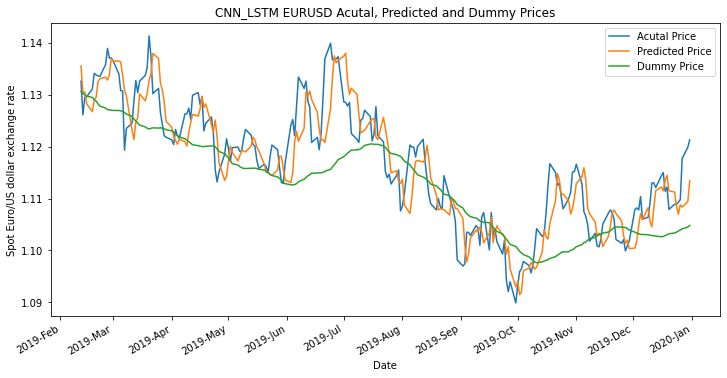

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

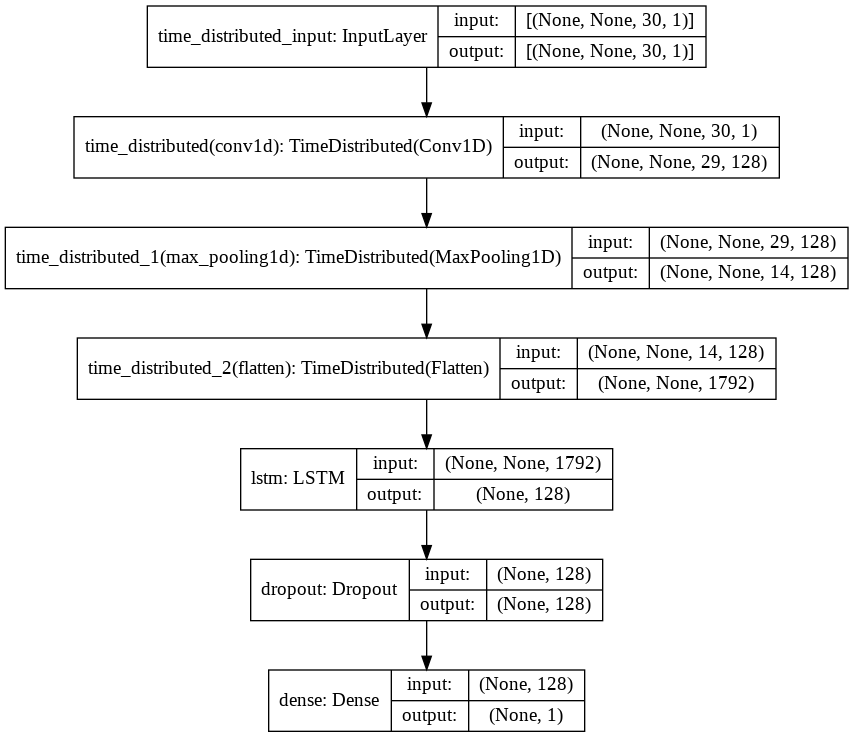

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.022097448617477426
RMSE:  0.14865210599745107
MAE:  0.12135812158563536
Dummy MSE:  0.0236885518332631
Dummy RMSE:  0.15391085677515767
Dummy MAE:  0.11970302826636056


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_EURUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_EURUSD/assets
